In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import os

In [3]:
!pip install pyedflib

In [4]:
import pyedflib
import numpy as np

def _read_py_function(filename, num_channels=64):
    # Open the EDF file
    f = pyedflib.EdfReader(filename)
    
    # Get the number of channels and the signal labels
    n_channels = f.signals_in_file
    print(f"Total channels in file: {n_channels}")
    
    # Ensure that we are fetching only the desired number of channels (16 in this case)
    if num_channels > n_channels:
        raise ValueError(f"The file contains only {n_channels} channels, but {num_channels} were requested.")
    
    # Initialize eeg_data to store only the first `num_channels`
    eeg_data = np.zeros((num_channels, f.getNSamples()[0]), dtype=np.float32)
    
    # Read only the first `num_channels` channels
    for i in range(num_channels):
        eeg_data[i, :] = f.readSignal(i)

    n_samples = f.getNSamples()[0]
    reminder = int(n_samples % 160)
    
    # Print statement to check values
    print(f"Original n_samples: {n_samples}")
    print(f"Reminder: {reminder}")
    
    n_samples -= reminder
    seconds = int(n_samples / 160)
    
    # Extract person_id from the filename
    path = filename.split("\\")
    person_id = int(path[-1].partition("S")[2].partition("R")[0])
    
    # Create one-hot encoded labels
    label = np.zeros(3, dtype=bool)
    label[person_id-1] = 1
    labels = np.tile(label, (seconds, 1))
    
    # Normalization step
    for i in range(num_channels):
        channel_data = eeg_data[i, :]
        mean_i = np.mean(channel_data)  # Compute mean of channel i
        std_i = np.std(channel_data)    # Compute standard deviation of channel i
        
        if std_i != 0:  # Avoid division by zero
            eeg_data[i, :] = (channel_data - mean_i) / std_i  # Normalize channel i

    # Transpose the data to shape (n_samples, n_channels)
    eeg_data = eeg_data.T
    
    if reminder > 0:
        eeg_data = eeg_data[:-reminder, :]
    
    # Split the data into 160-sample chunks
    intervals = np.linspace(0, n_samples, num=seconds, endpoint=False, dtype=int)
    eeg_data = np.split(eeg_data, intervals)
    del eeg_data[0]
    eeg_data = np.array(eeg_data)
    
    return eeg_data, labels


In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_eeg_data_with_pyedflib(data_path, max_subjects=3):
    # Initialize the global variables
    global subject_data, all_train_data, all_train_labels, all_test_data, all_test_labels
    global train_data, val_data, train_labels, val_labels

    # Initialize the variables before using them
    subject_data = {}
    all_train_data = []
    all_train_labels = []
    all_test_data = []
    all_test_labels = []

    subject_count = 0  # Counter to track the number of subjects processed

    for subject_dir in os.listdir(data_path):
        subject_path = os.path.join(data_path, subject_dir)
        if os.path.isdir(subject_path):
            print(f"Processing subject: {subject_dir}")
            subject_data[subject_dir] = {}
            for recording_file in os.listdir(subject_path):
                recording_path = os.path.join(subject_path, recording_file)
                if recording_file.endswith('.edf'):
                    recording_id = os.path.splitext(recording_file)[0]
                    print(f"Loading recording: {recording_file}")

                    try:
                        #eeg_data, labels = _read_py_function(recording_path)
                        eeg_data, labels = _read_py_function(recording_path)

                        print(f"Data shape after processing: {eeg_data.shape}")
                        print(f"Labels shape: {labels.shape}")

                        train_data, test_data, train_labels, test_labels = train_test_split(
                            eeg_data, labels, test_size=0.1, random_state=42
                        )
                        
                        all_train_data.append(train_data)
                        all_train_labels.append(train_labels)
                        all_test_data.append(test_data)
                        all_test_labels.append(test_labels)

                    except Exception as e:
                        print(f"Error loading {recording_file}: {e}")

            subject_count += 1  # Increment the subject counter

            # Stop processing once the desired number of subjects is reached
            if subject_count >= max_subjects:
                print(f"Processed {max_subjects} subjects. Stopping further processing.")
                break

    print(f"Train data list length: {len(all_train_data)}")
    print(f"Train labels list length: {len(all_train_labels)}")
    print(f"Test data list length: {len(all_test_data)}")
    print(f"Test labels list length: {len(all_test_labels)}")

    if all_train_data and all_train_labels:
        all_train_data = np.concatenate(all_train_data, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
    else:
        print("No training data loaded.")
        return None, None, None, None, None, None

    if all_test_data and all_test_labels:
        all_test_data = np.concatenate(all_test_data, axis=0)
        all_test_labels = np.concatenate(all_test_labels, axis=0)
    else:
        print("No test data loaded.")
        return None, None, None, None, None, None

    if len(all_train_data) == 0 or len(all_train_labels) == 0:
        print("No data available for splitting into training and validation sets.")
        return None, None, None, None, None, None

    # Split train data further into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(
        all_train_data, all_train_labels, test_size=0.25, random_state=42
    )

    return train_data, train_labels, val_data, val_labels, all_test_data, all_test_labels


In [6]:
data_path = r"C:\Users\akhileshsing2024\Downloads\eeg-motor-movementimagery-dataset-1.0.0\files"
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_eeg_data_with_pyedflib(data_path)
# Access global variables directly if needed
print(f"Train data shape: {train_data.shape if train_data is not None else 'None'}")
print(f"Validation data shape: {val_data.shape if val_data is not None else 'None'}")
print(f"Test data shape: {test_data.shape if test_data is not None else 'None'}")

Processing subject: S001
Loading recording: S001R01.edf
Total channels in file: 64
Original n_samples: 9760
Reminder: 0
Data shape after processing: (61, 160, 64)
Labels shape: (61, 3)
Loading recording: S001R02.edf
Total channels in file: 64
Original n_samples: 9760
Reminder: 0
Data shape after processing: (61, 160, 64)
Labels shape: (61, 3)
Loading recording: S001R03.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 64)
Labels shape: (125, 3)
Loading recording: S001R04.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 64)
Labels shape: (125, 3)
Loading recording: S001R05.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 64)
Labels shape: (125, 3)
Loading recording: S001R06.edf
Total channels in file: 64
Original n_samples: 20000
Reminder: 0
Data shape after processing: (125, 160, 64)
Labels shape: (125, 3)
Loa

In [31]:
import tensorflow as tf
import numpy as np

import tensorflow as tf
import numpy as np

# def chebyshev_coefficients(order):
#     """Generate Chebyshev coefficients for an approximation of ReLU."""
#     # For simplicity, use a pre-defined order of coefficients.
#     # A typical Chebyshev polynomial approximation of ReLU could be a 4th order or 3rd order approximation
#     # with manually calculated coefficients. Here, we will use 3 coefficients for the first few orders.
#     # These coefficients are for approximating ReLU using a Chebyshev polynomial.
    
#     if order == 3:
#         return [0, 1.0, 0.0, 0.0]  # ReLU approximation with a simple Chebyshev polynomial
#     elif order == 4:
#         return [0, 1.0, -0.5, 0.25]  # Higher order approximation for ReLU
#     else:
#         raise ValueError(f"Unsupported order {order}. Use 3 or 4.")

# class ChebyshevReLU(tf.keras.layers.Layer):
#     def __init__(self, order=3, **kwargs):
#         super(ChebyshevReLU, self).__init__(**kwargs)
#         self.coefficients = chebyshev_coefficients(order)

#     def call(self, inputs):
#         """Apply Chebyshev approximation to ReLU."""
#         # Clip inputs to a reasonable range to avoid very large values
#         inputs = tf.clip_by_value(inputs, -5.0, 5.0)  # You can adjust the clipping range based on your data

#         # Chebyshev polynomial: T_0(x) = 1, T_1(x) = x, T_2(x) = 2x^2 - 1, ...
#         # Using 3 coefficients for a simple ReLU approximation
#         chebyshev_approx = self.coefficients[0] + self.coefficients[1] * inputs + \
#                            self.coefficients[2] * tf.square(inputs) + self.coefficients[3] * tf.pow(inputs, 3)

#         # Apply ReLU condition, as Chebyshev ReLU should act like ReLU above 0
#         return tf.maximum(chebyshev_approx, 0)

#     def compute_output_shape(self, input_shape):
#         return input_shape

import tensorflow as tf
import numpy as np

def generate_chebyshev_coefficients(order):
    """Dynamically generate Chebyshev coefficients for an approximation of ReLU."""
    # Initialize the coefficients array for Chebyshev polynomial approximation of order 'order'
    coefficients = [0] * (order + 1)
    
    # Set coefficients to approximate ReLU
    # Chebyshev polynomial of the first kind: T_0(x) = 1, T_1(x) = x, T_2(x) = 2x^2 - 1, T_3(x) = 4x^3 - 3x, ...
    # We approximate ReLU(x) using a truncated series of these polynomials
    for n in range(order + 1):
        if n % 2 != 0:  # Use only odd terms to approximate ReLU's nonlinearity
            coefficients[n] = 2 / (np.pi * n)  # This is a simple approximation; you can refine as needed

    return coefficients

class ChebyshevReLU(tf.keras.layers.Layer):
    def __init__(self, order=3, **kwargs):
        super(ChebyshevReLU, self).__init__(**kwargs)
        self.coefficients = generate_chebyshev_coefficients(order)
        self.order = order

    def call(self, inputs):
        """Apply Chebyshev approximation to ReLU."""
        # Clip inputs to a reasonable range to avoid very large values
        inputs = tf.clip_by_value(inputs, -5.0, 5.0)

        # Initialize with the first term of the Chebyshev polynomial (T_0(x) = 1)
        chebyshev_approx = self.coefficients[0]

        # Iteratively add terms for the Chebyshev polynomial approximation
        for n in range(1, self.order + 1):
            if n == 1:
                term = self.coefficients[n] * inputs  # T_1(x) = x
            else:
                term = self.coefficients[n] * tf.math.pow(inputs, n)
            chebyshev_approx += term

        # Apply ReLU condition
        return tf.maximum(chebyshev_approx, 0)

    def compute_output_shape(self, input_shape):
        return input_shape

class PolynomialSoftmax(tf.keras.layers.Layer):
    def __init__(self):
        super(PolynomialSoftmax, self).__init__()

    def call(self, x):
        # Apply a polynomial approximation of exponential function: exp(x) ≈ 1 + x + 0.5 * x^2
        poly_exp = 1 + x + 0.5 * tf.square(x)

        # Sum across classes (last dimension) to normalize
        sum_poly_exp = tf.reduce_sum(poly_exp, axis=-1, keepdims=True)
        
        # Divide by sum to approximate softmax behavior
        return poly_exp / sum_poly_exp

def eeg_biometric_identification_model(input_shape, n_classes, lstm_size=192, keep_prob=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    # 1D Convolutional Layers with Chebyshev ReLU approximation
    conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, padding='same')(inputs)
    conv1 = ChebyshevReLU()(conv1)
    
    conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='same')(conv1)
    conv2 = ChebyshevReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='same')(conv2)
    conv3 = ChebyshevReLU()(conv3)

    conv4 = tf.keras.layers.Conv1D(filters=1024, kernel_size=2, strides=1, padding='same')(conv3)
    conv4 = ChebyshevReLU()(conv4)

    # Flatten the convolution output before feeding into fully connected layers
    flatten = tf.keras.layers.Flatten()(conv4)

    # Fully connected layer with 192 neurons and dropout
    fc1 = tf.keras.layers.Dense(units=192)(flatten)
    fc1 = ChebyshevReLU()(fc1)
    dropout_fc1 = tf.keras.layers.Dropout(rate=1 - keep_prob)(fc1)

    # Reshape to (batch_size, timesteps=1, features=192) for LSTM input
    lstm_input = tf.keras.layers.Reshape((1, 192))(dropout_fc1)  

    # Add LSTM layers
    lstm_out = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True)(lstm_input)
    lstm_out = tf.keras.layers.LSTM(units=lstm_size, return_sequences=False)(lstm_out)

    # Fully connected layer after LSTM
    fc2 = tf.keras.layers.Dense(units=192)(lstm_out)
    fc2 = ChebyshevReLU()(fc2)
    
    # Output layer with n_classes units
    output = tf.keras.layers.Dense(units=n_classes)(fc2)
    output = PolynomialSoftmax()(output)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model


# # Define the model, using ChebyshevReLU as the activation function
# def eeg_biometric_identification_model(input_shape, n_classes, lstm_size=192, keep_prob=0.5):
#     inputs = tf.keras.Input(shape=input_shape)

#     # 1D Convolutional Layers with Chebyshev ReLU approximation
#     conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, padding='same')(inputs)
#     conv1 = ChebyshevReLU()(conv1)  # Apply Chebyshev approximation for ReLU
    
#     conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='same')(conv1)
#     conv2 = ChebyshevReLU()(conv2)

#     conv3 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='same')(conv2)
#     conv3 = ChebyshevReLU()(conv3)

#     conv4 = tf.keras.layers.Conv1D(filters=1024, kernel_size=2, strides=1, padding='same')(conv3)
#     conv4 = ChebyshevReLU()(conv4)

#     # Flatten the convolution output before feeding into fully connected layers
#     flatten = tf.keras.layers.Flatten()(conv4)

#     # Fully connected layer with 192 neurons and dropout
#     fc1 = tf.keras.layers.Dense(units=192)(flatten)
#     fc1 = ChebyshevReLU()(fc1)
#     dropout_fc1 = tf.keras.layers.Dropout(rate=1 - keep_prob)(fc1)

#     # Reshape to (batch_size, timesteps=1, features=192) for LSTM input
#     lstm_input = tf.keras.layers.Reshape((1, 192))(dropout_fc1)  

#     # Add LSTM layers
#     lstm_out = tf.keras.layers.LSTM(units=lstm_size, return_sequences=True)(lstm_input)  # First LSTM layer
#     lstm_out = tf.keras.layers.LSTM(units=lstm_size, return_sequences=False)(lstm_out)  # Second LSTM layer

#     # Fully connected layers after LSTM
#     fc2 = tf.keras.layers.Dense(units=192)(lstm_out)
#     fc2 = ChebyshevReLU()(fc2)
#     fc3 = tf.keras.layers.Dense(units=192)(fc2)
#     fc3 = ChebyshevReLU()(fc3)

#     # Output layer (Softmax for classification)
#     output = tf.keras.layers.Dense(n_classes, activation='softmax')(fc3)

#     # Create the model
#     model = tf.keras.Model(inputs=inputs, outputs=output)

#     return model


# Example usage
input_shape = (160, 64)  # 160 samples, 64 channels (1-second EEG recording)
n_classes = 3  # Number of subjects
keep_prob = 0.5  # Dropout rate

model = eeg_biometric_identification_model(input_shape, n_classes, lstm_size=192, keep_prob=keep_prob)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 160, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 160, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ chebyshev_re_lu_78              │ (None, 160, 128)       │             0 │
│ (ChebyshevReLU)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 160, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ chebyshev_re_lu_79              │ (None, 160, 256)       │             0 │
│ (ChebyshevReLU)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 160, 512)       │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ chebyshev_re_lu_80              │ (None, 160, 512)       │             0 │
│ (ChebyshevReLU)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 160, 1024)      │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ chebyshev_re_lu_81              │ (None, 160, 1024)      │             0 │
│ (ChebyshevReLU)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 163840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 192)            │    31,457,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ chebyshev_re_lu_82              │ (None, 192)            │             0 │
│ (ChebyshevReLU)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 1, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 1, 192)         │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 192)            │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ chebyshev_re_lu_83              │ (None, 192)            │             0 │
│ (ChebyshevReLU)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           579 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ polynomial_softmax_3            │ (None, 3)              │             0 │
│ (PolynomialSoftmax)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,481,027 (127.72 MB)

 Trainable params: 33,481,027 (127.72 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
import tensorflow as tf

def train_model(model, train_data, train_labels, val_data, val_labels, epochs=20, batch_size=80):
    # Define checkpoint path and callback to save the best model
    checkpoint_path = "cp-best.weights.h5"  # Save only the best model based on validation loss
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     save_best_only=True,  # Save only the best model
                                                     monitor='val_loss',   # Monitor validation loss
                                                     verbose=1)
    
    # Define early stopping callback to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5,  # Stop after 5 epochs of no improvement
                                                      restore_best_weights=True,
                                                      verbose=1)
    
    # Define TensorBoard callback for monitoring training process
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

    # Save the initial weights (optional)
    initial_weights_path = "cp-initial.weights.h5"
    model.save_weights(initial_weights_path)

    # Training the model
    with tf.device('/GPU:0'):  # Ensure training uses the GPU
        history = model.fit(
            train_data, train_labels,
            epochs=epochs,
            validation_data=(val_data, val_labels),
            batch_size=batch_size,
            callbacks=[cp_callback, early_stopping, tensorboard_callback]
        )

    return history

# Example usage
history = train_model(model, train_data, train_labels, val_data, val_labels, epochs=20, batch_size=80)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7696 - loss: 0.5335
Epoch 1: val_loss improved from inf to 0.47012, saving model to cp-best.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step - accuracy: 0.7695 - loss: 0.5337 - val_accuracy: 0.7895 - val_loss: 0.4701
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7608 - loss: 0.5148
Epoch 2: val_loss improved from 0.47012 to 0.46410, saving model to cp-best.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - accuracy: 0.7610 - loss: 0.5145 - val_accuracy: 0.7941 - val_loss: 0.4641
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7805 - loss: 0.5025
Epoch 3: val_loss did not improve from 0.46410
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step - accuracy: 0.7805 - loss: 0.5023 - val_accuracy: 0.7701 - val_loss: 0.5065
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7913 - loss: 0.4713
Epoch 4: val_loss improved from 0.46410 to 0.44010, saving model to cp-best.weights.h

In [34]:



# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x=test_data, y=test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9355 - loss: 0.2311
Test Loss: 0.19506417214870453
Test Accuracy: 0.9450980424880981


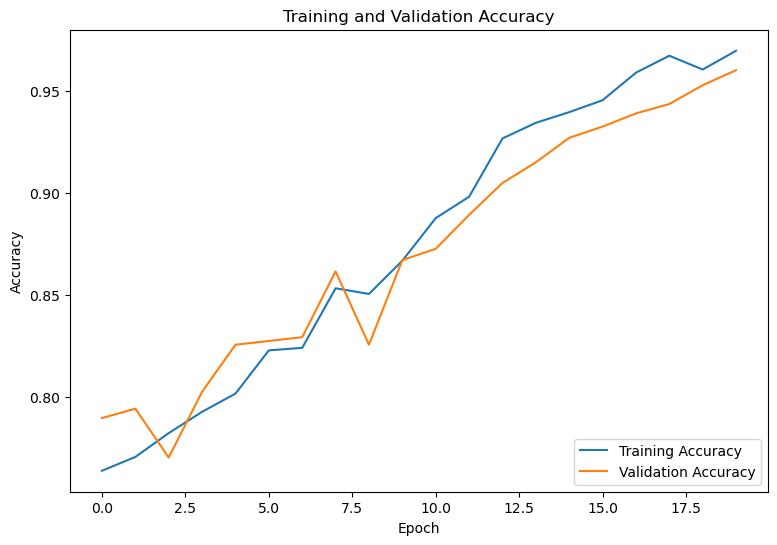

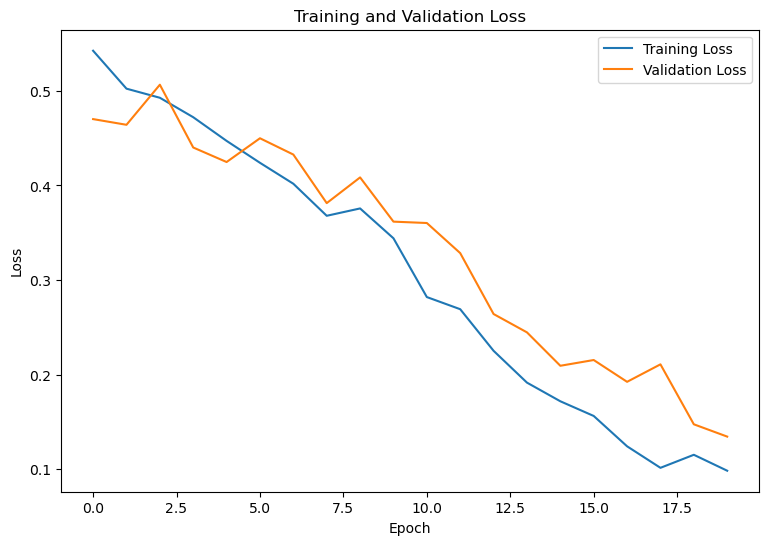

In [35]:
import matplotlib.pyplot as plt

# Extract the history data
history_data = history.history

# Plot training and validation accuracy
plt.figure(figsize=(9, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.savefig("accuracy_plot.png")  # Save the accuracy plot
plt.show()

# Plot training and validation loss
plt.figure(figsize=(9, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig("loss_plot.png")  # Save the loss plot
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Confusion Matrix:
[[154   3  13]
 [  1 169   0]
 [ 11   0 159]]


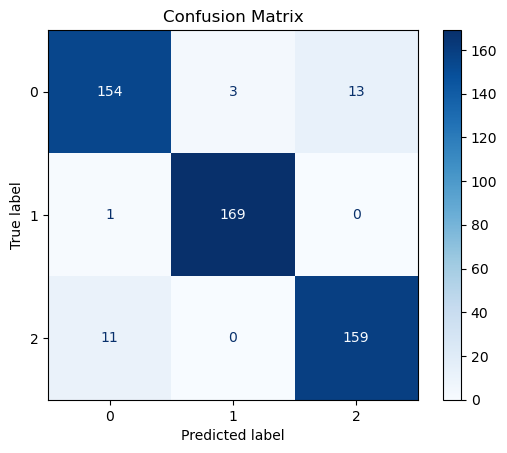

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the predictions from the model on the test data
predictions = model.predict(test_data)

# Convert the predicted probabilities into class predictions (argmax over class probabilities)
predicted_classes = np.argmax(predictions, axis=1)

# Convert the one-hot encoded test labels back to their original class labels
true_classes = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()